In [1]:
!pip install transformers datasets evaluate scikit-learn matplotlib -q

import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset, concatenate_datasets
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    TrainerCallback
)
from torch.optim import AdamW
from evaluate import load as load_metric
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
from sklearn.preprocessing import label_binarize
from scipy.special import softmax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00


In [2]:

dataset_name = "atrost/financial_phrasebank"
raw_dataset = load_dataset(dataset_name)

combined_dataset = concatenate_datasets([
    raw_dataset['train'],
    raw_dataset['validation'],
    raw_dataset['test']
])

# Combine the existing train, validation, and test splits into one single dataset
combined_dataset = combined_dataset.rename_column("label", "labels")
labels_list = ["negative", "neutral", "positive"]
id2label = {i: label for i, label in enumerate(labels_list)}
label2id = {label: i for i, label in enumerate(labels_list)}

# Re-create the paper's 64% train / 16% validation / 20% test split
full_train_val_ds = combined_dataset.train_test_split(
    test_size=0.2, seed=42
)
train_val_ds = full_train_val_ds['train'].train_test_split(
    test_size=0.2, seed=42
)

train_dataset = train_val_ds['train']
val_dataset = train_val_ds['test']
test_dataset = full_train_val_ds['test']

print(f"Total size: {len(combined_dataset)}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/721 [00:00<?, ?B/s]

data/train-00000-of-00001-138b53eb17a3e8(…):   0%|          | 0.00/268k [00:00<?, ?B/s]

data/validation-00000-of-00001-0876be41e(…):   0%|          | 0.00/68.7k [00:00<?, ?B/s]

data/test-00000-of-00001-41c7ea948573445(…):   0%|          | 0.00/82.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/776 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/970 [00:00<?, ? examples/s]

Total size: 4846
Train dataset size: 3100
Validation dataset size: 776
Test dataset size: 970


In [3]:
# Pre-trained model checkpoint name (BERT-base, uncased version)
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# Maximum sequence length (number of tokens) based on the paper's specification
max_length = 64

# Will tokenize a batch of examples (sentences)
def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=max_length
    )

# Apply the tokenize_function to the datasets in batches for efficiency
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

Map:   0%|          | 0/776 [00:00<?, ? examples/s]

Map:   0%|          | 0/970 [00:00<?, ? examples/s]

In [4]:
# Load all metrics
accuracy_metric = load_metric("accuracy")
f1_metric = load_metric("f1")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")

# The Trainer will call this helper to compute metrics during evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")["f1"]
    precision = precision_metric.compute(predictions=predictions, references=labels, average="macro")["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels, average="macro")["recall"]

    return { "accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall }

In [5]:
# Gradual Unfreezing Callback - implements the paper's schedule: "after each third of a training epoch we unfreeze the next layer"
class GradualUnfreezingCallback(TrainerCallback):
    def on_train_begin(self, args, state, control, **kwargs):
        model = kwargs['model']
        train_dataloader = kwargs['train_dataloader']

        print("--- Freezing embeddings and all 12 BERT encoder layers ---")
        # Freeze embeddings and all 12 encoder layers
        for param in model.bert.embeddings.parameters():
            param.requires_grad = False
        for layer in model.bert.encoder.layer:
            for param in layer.parameters():
                param.requires_grad = False

        # Ensure pooler and classifier head are unfrozen
        for param in model.bert.pooler.parameters():
            param.requires_grad = True
        for param in model.classifier.parameters():
            param.requires_grad = True

        # Track how many layers have been unfrozen
        self.num_layers_unfrozen = 0
        self.steps_in_epoch = len(train_dataloader)
        print(f"--- Steps per epoch calculated: {self.steps_in_epoch} ---")

    def on_step_end(self, args, state, control, **kwargs):
        model = kwargs['model']

        if self.steps_in_epoch == 0:
            return

        # Calculate the step interval for unfreezing (1/3rd of an epoch)
        unfreeze_trigger_step_interval = max(1, int(self.steps_in_epoch / 3))

        # Unfreeze 3 layers per epoch
        target_layers_unfrozen = min(12, int(state.global_step / unfreeze_trigger_step_interval))

        if target_layers_unfrozen > self.num_layers_unfrozen:

            # Calculate how many layers to unfreeze now
            num_to_unfreeze_now = target_layers_unfrozen - self.num_layers_unfrozen

            for _ in range(num_to_unfreeze_now):
                # Stop if already unfrozen all 12 layers
                if self.num_layers_unfrozen >= 12:
                    break

                # Unfreeze from top (11) down to bottom (0)
                layer_index_to_unfreeze = 11 - self.num_layers_unfrozen

                print(f"--- Step {state.global_step}: Unfreezing BERT encoder layer {layer_index_to_unfreeze} ---")

                for param in model.bert.encoder.layer[layer_index_to_unfreeze].parameters():
                    param.requires_grad = True

                self.num_layers_unfrozen += 1

# Custom Trainer for Discriminative Learning Rates
class DiscriminativeLRsTrainer(Trainer):
    def create_optimizer(self):
        print("--- Creating optimizer with discriminative learning rates ---")

        # Get the hyperparameters from TrainingArguments
        lr = self.args.learning_rate
        weight_decay = self.args.weight_decay
        adam_beta1 = self.args.adam_beta1
        adam_beta2 = self.args.adam_beta2
        adam_epsilon = self.args.adam_epsilon

        # The paper used a discrimination rate of 0.85
        discrimination_rate = 0.85

        # Define the two parameter groups
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.model.bert.named_parameters() if p.requires_grad],
                "lr": lr * discrimination_rate,
                "weight_decay": weight_decay,
            },
            {
                "params": [p for n, p in self.model.classifier.named_parameters() if p.requires_grad],
                "lr": lr,
                "weight_decay": weight_decay,
            },
        ]

        self.optimizer = AdamW(
            optimizer_grouped_parameters,
            lr=lr,
            betas=(adam_beta1, adam_beta2),
            eps=adam_epsilon,
        )
        return self.optimizer

In [6]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

# Set up TrainingArguments
training_args = TrainingArguments(
    output_dir="finbert_reproduction_advanced",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=6,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    # warmup_ratio=0.2 and lr_scheduler_type="linear" for slanted triangular learning rate
    lr_scheduler_type="linear",
    warmup_ratio=0.2,
    push_to_hub=False,
    logging_strategy="epoch"
)

# Create the Trainer object
trainer = DiscriminativeLRsTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[GradualUnfreezingCallback()],
)


trainer.train()
print("Training complete.")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1570813373.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DiscriminativeLRsTrainer.__init__`. Use `processing_class` instead.
  trainer = DiscriminativeLRsTrainer(


--- Creating optimizer with discriminative learning rates ---


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: harsha55raj (harsha55raj-university-of-south-florida) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


--- Freezing embeddings and all 12 BERT encoder layers ---
--- Steps per epoch calculated: 49 ---


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.029500,0.931574,0.574742,0.243317,0.191581,0.333333
2,0.786400,0.623059,0.735825,0.671857,0.732470,0.643478
3,0.518400,0.413929,0.835052,0.825491,0.820664,0.830775
4,0.357600,0.376943,0.846649,0.847048,0.833671,0.863736
5,0.286600,0.356375,0.859536,0.858005,0.851366,0.865284
6,0.240400,0.352240,0.860825,0.856608,0.855447,0.858274


--- Step 16: Unfreezing BERT encoder layer 11 ---
--- Step 32: Unfreezing BERT encoder layer 10 ---
--- Step 48: Unfreezing BERT encoder layer 9 ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--- Step 64: Unfreezing BERT encoder layer 8 ---
--- Step 80: Unfreezing BERT encoder layer 7 ---
--- Step 96: Unfreezing BERT encoder layer 6 ---
--- Step 112: Unfreezing BERT encoder layer 5 ---
--- Step 128: Unfreezing BERT encoder layer 4 ---
--- Step 144: Unfreezing BERT encoder layer 3 ---
--- Step 160: Unfreezing BERT encoder layer 2 ---
--- Step 176: Unfreezing BERT encoder layer 1 ---
--- Step 192: Unfreezing BERT encoder layer 0 ---
Training complete.



--- Starting Final Evaluation on Test Set ---



--- Classification Report ---
              precision    recall  f1-score   support

    negative       0.80      0.91      0.85       127
     neutral       0.93      0.88      0.90       594
    positive       0.79      0.83      0.81       249

    accuracy                           0.87       970
   macro avg       0.84      0.87      0.85       970
weighted avg       0.87      0.87      0.87       970


--- Comparison to FinBERT Paper ---
Our Model: Accuracy = 0.87, Macro-F1 = 0.85
Paper Model: Accuracy = 0.86, Macro-F1 = 0.84


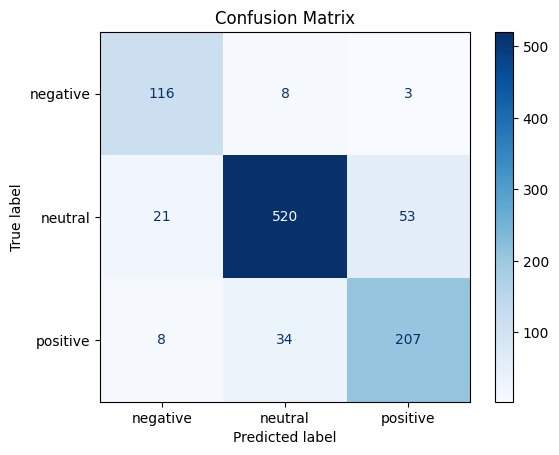


Macro-Averaged AUROC (One-vs-Rest): 0.9613
--- Generating AUROC Curve (One-vs-Rest) ---


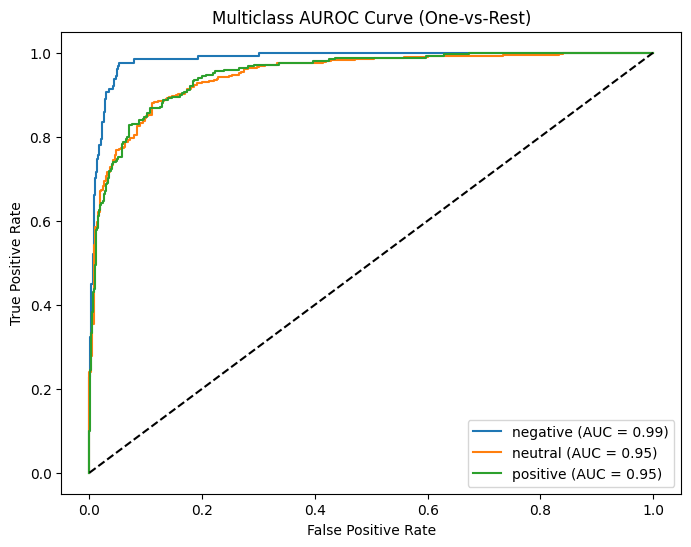

--- Generating Precision-Recall Curve (One-vs-Rest) ---


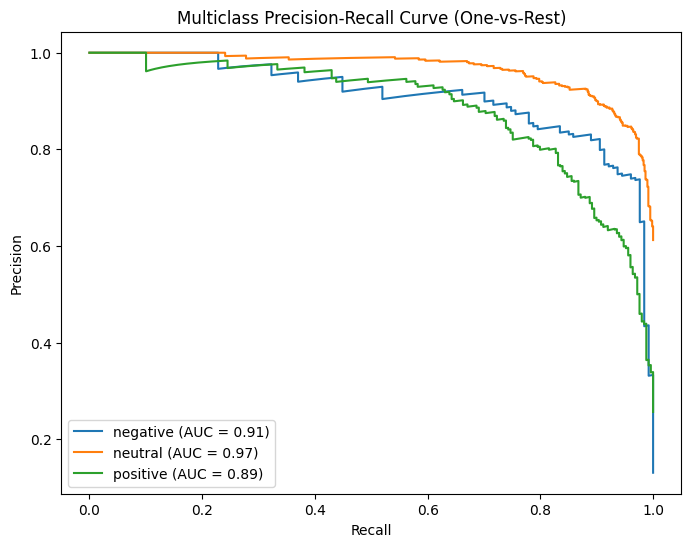

In [7]:
# Final Evaluation & Metrics

print("\n--- Starting Final Evaluation on Test Set ---")
predictions = trainer.predict(tokenized_test)
y_logits = predictions.predictions
y_scores = softmax(y_logits, axis=1)
y_preds = np.argmax(y_logits, axis=-1)
y_true = predictions.label_ids

print("\n--- Classification Report ---")
print(classification_report(y_true, y_preds, target_names=labels_list))

my_accuracy = accuracy_metric.compute(predictions=y_preds, references=y_true)["accuracy"]
my_f1 = f1_metric.compute(predictions=y_preds, references=y_true, average="macro")["f1"]

print("\n--- Comparison to FinBERT Paper ---")
print(f"Our Model: Accuracy = {my_accuracy:.2f}, Macro-F1 = {my_f1:.2f}")
print("Paper Model: Accuracy = 0.86, Macro-F1 = 0.84")

cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_list)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

macro_roc_auc_ovr = roc_auc_score(y_true, y_scores, multi_class="ovr", average="macro")
print(f"\nMacro-Averaged AUROC (One-vs-Rest): {macro_roc_auc_ovr:.4f}")

print("--- Generating AUROC Curve (One-vs-Rest) ---")
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])
n_classes = 3
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{labels_list[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass AUROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

print("--- Generating Precision-Recall Curve (One-vs-Rest) ---")
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_binarized[:, i], y_scores[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{labels_list[i]} (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multiclass Precision-Recall Curve (One-vs-Rest)')
plt.legend(loc='best')
plt.show()